#**WQU Capstone**
**Group Number: 5468**


*   Track 1: Commodities - Research
*   Topic 1: Energy Products Relationships in Different Markets
*   Title: Understanding and Analyzing Energy Product Price Relationships Across Global Markets


In [146]:
!pip install arch

In [147]:
import pandas as pd
from arch import arch_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from statsmodels.tsa.vector_ar.var_model import VAR
from keras.models import Sequential
from keras.layers import LSTM, Dense
import warnings

warnings.filterwarnings("ignore")

#**STEP 1: Data Collection**

In [148]:
def collect_data():
    # Load data from CSV files
    BFOE = 'https://raw.githubusercontent.com/shivanivermapro/WQU-Capstone-Project/main/BFOE.csv?token=GHSAT0AAAAAACRJ326QD7DUOPOWLAPY2A5EZRGP2TQ'
    Bonny_Light = 'https://raw.githubusercontent.com/shivanivermapro/WQU-Capstone-Project/main/Bonny_Light.csv?token=GHSAT0AAAAAACRJ326QMHRKWABVNAUN4Z24ZRGP4JA'
    Europe_Brent = 'https://raw.githubusercontent.com/shivanivermapro/WQU-Capstone-Project/main/Europe_Brent.csv?token=GHSAT0AAAAAACRJ326RYZSDV4PZMXOZPUCUZRGP6FQ'
    WTI = 'https://raw.githubusercontent.com/shivanivermapro/WQU-Capstone-Project/main/WTI.csv?token=GHSAT0AAAAAACRJ326QMOYY4U6TIV5QWBXOZRGP74Q'
    Conventional_Gasoline = 'https://raw.githubusercontent.com/shivanivermapro/WQU-Capstone-Project/main/Conventional_Gasoline.csv?token=GHSAT0AAAAAACRJ326QGCZTJK7GEZOQWLF4ZRGQARQ'
    Diesel_Fuel = 'https://raw.githubusercontent.com/shivanivermapro/WQU-Capstone-Project/main/Diesel_Fuel.csv?token=GHSAT0AAAAAACRJ326QBCYG26A35TOPUYKIZRGQBNA'
    Heating_Oil = 'https://raw.githubusercontent.com/shivanivermapro/WQU-Capstone-Project/main/Heating_Oil.csv?token=GHSAT0AAAAAACRJ326RXVM5ZGVAI4H7DR26ZRGQCSA'
    Propane = 'https://raw.githubusercontent.com/shivanivermapro/WQU-Capstone-Project/main/Propane.csv?token=GHSAT0AAAAAACRJ326RRP2E7SP4W77EKHKWZRGQDKQ'
    Regular_Gasoline = 'https://raw.githubusercontent.com/shivanivermapro/WQU-Capstone-Project/main/Regular_Gasoline.csv?token=GHSAT0AAAAAACRJ326RQBEAYV2VE3OATFBGZRGQD7Q'

    # Read data into DataFrames
    BFOE_df = pd.read_csv(BFOE, index_col=0, parse_dates=[0])
    Bonny_Light_df = pd.read_csv(Bonny_Light, index_col=0, parse_dates=[0])
    Europe_Brent_df = pd.read_csv(Europe_Brent, skiprows=4, index_col=0, parse_dates=[0])
    WTI_df = pd.read_csv(WTI, skiprows=4, index_col=0, parse_dates=[0])
    Conventional_Gasoline_df = pd.read_csv(Conventional_Gasoline, index_col=0, parse_dates=[0])
    Diesel_Fuel_df = pd.read_csv(Diesel_Fuel, index_col=0, parse_dates=[0])
    Heating_Oil_df = pd.read_csv(Heating_Oil, index_col=0, parse_dates=[0])
    Propane_df = pd.read_csv(Propane, index_col=0, parse_dates=[0])
    Regular_Gasoline_df = pd.read_csv(Regular_Gasoline, index_col=0, parse_dates=[0])

    # Filter data based on a consistent date range
    date_range = slice('2010-01-01', '2023-12-31')
    BFOE_df = BFOE_df.loc[date_range]
    Bonny_Light_df = Bonny_Light_df.loc[date_range]
    Europe_Brent_df = Europe_Brent_df.loc[date_range]
    WTI_df = WTI_df.loc[date_range]
    Conventional_Gasoline_df = Conventional_Gasoline_df.loc[date_range]
    Diesel_Fuel_df = Diesel_Fuel_df.loc[date_range]
    Heating_Oil_df = Heating_Oil_df.loc[date_range]
    Propane_df = Propane_df.loc[date_range]
    Regular_Gasoline_df = Regular_Gasoline_df.loc[date_range]

    return BFOE_df, Bonny_Light_df, Europe_Brent_df, WTI_df, Conventional_Gasoline_df, Diesel_Fuel_df, Heating_Oil_df, Propane_df, Regular_Gasoline_df

# Collect data
BFOE_df, Bonny_Light_df, Europe_Brent_df, WTI_df, Conventional_Gasoline_df, Diesel_Fuel_df, Heating_Oil_df, Propane_df, Regular_Gasoline_df = collect_data()

#**STEP 2: Data Preprocessing**

In [149]:
def preprocess_data(df, zero_handling=[], negative_handling=[], blank_handling='ffill', outlier_threshold=3):
    df.fillna(method=blank_handling, inplace=True)

    for column in zero_handling:
        df[column].replace(0, np.nan, inplace=True)
        df[column].fillna(method=blank_handling, inplace=True)

    for column in negative_handling:
        df[column].clip(lower=0, inplace=True)

    for column in df.columns:
        mean = df[column].mean()
        std = df[column].std()
        outliers = (df[column] - mean).abs() > outlier_threshold * std
        df.loc[outliers, column] = np.nan
        df[column].fillna(method=blank_handling, inplace=True)

    return df

# Preprocess data
BFOE_df = preprocess_data(BFOE_df, zero_handling=['Bloomberg European Dated Brent Forties Oseberg Ekofisk (BFOE) Crude Oil Spot Price'])
Bonny_Light_df = preprocess_data(Bonny_Light_df, zero_handling=['Crude Oil Price in USD'])
Europe_Brent_df = preprocess_data(Europe_Brent_df, zero_handling=['Europe Brent Spot Price FOB Dollars per Barrel'])
WTI_df = preprocess_data(WTI_df, zero_handling=['Cushing OK WTI Spot Price FOB Dollars per Barrel'])
Conventional_Gasoline_df = preprocess_data(Conventional_Gasoline_df, zero_handling=['New York Harbor Conventional Gasoline Regular Spot Price FOB (Dollars per Gallon)'])
Diesel_Fuel_df = preprocess_data(Diesel_Fuel_df, zero_handling=['New York Harbor Ultra-Low Sulfur No 2 Diesel Spot Price (Dollars per Gallon)'])
Heating_Oil_df = preprocess_data(Heating_Oil_df, zero_handling=['New York Harbor No. 2 Heating Oil Spot Price FOB (Dollars per Gallon)'])
Propane_df = preprocess_data(Propane_df, zero_handling=['Mont Belvieu, TX Propane Spot Price FOB (Dollars per Gallon)'])
Regular_Gasoline_df = preprocess_data(Regular_Gasoline_df, zero_handling=['Los Angeles Reformulated RBOB Regular Gasoline Spot Price (Dollars per Gallon)'])



#**STEP 3: Time Series Analysis**

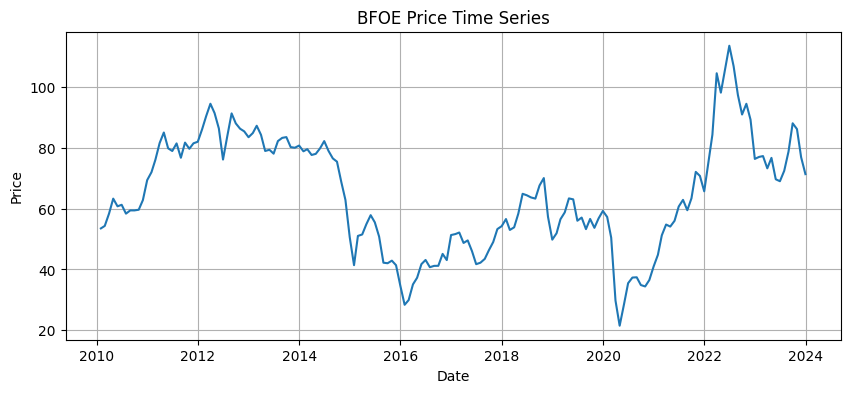

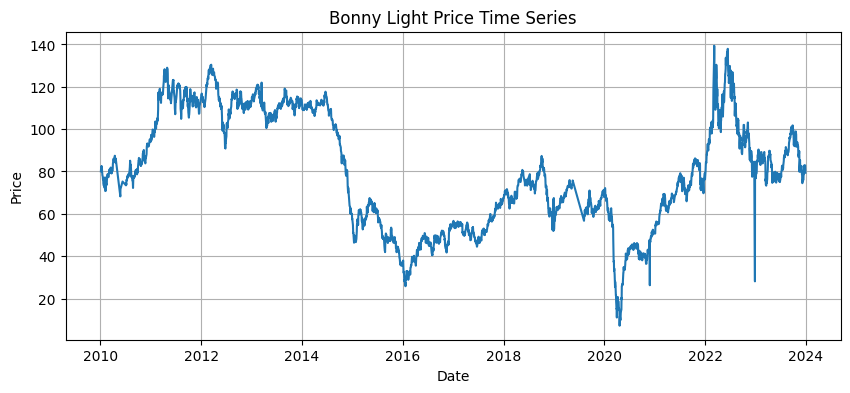

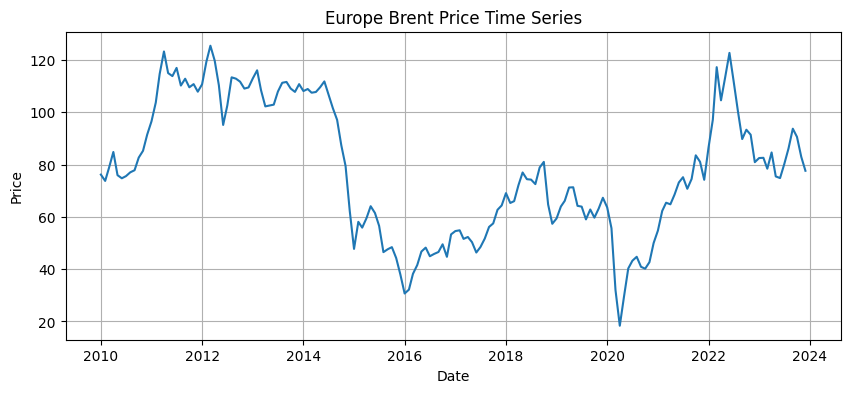

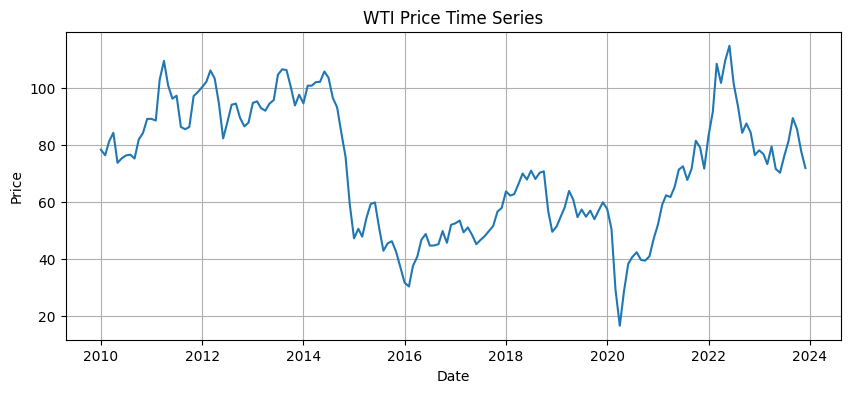

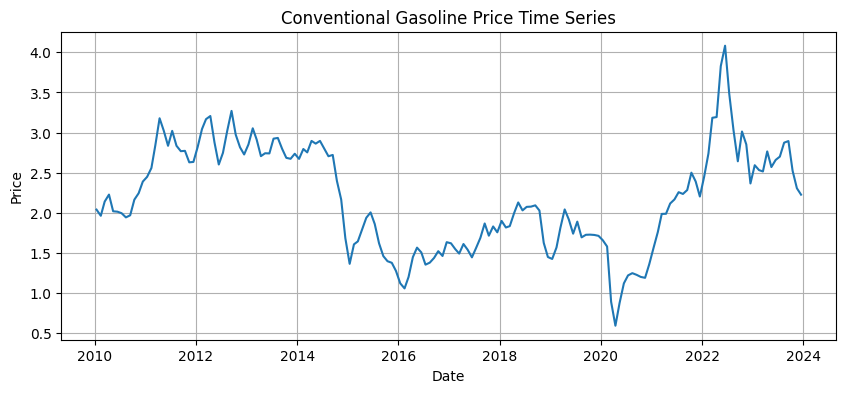

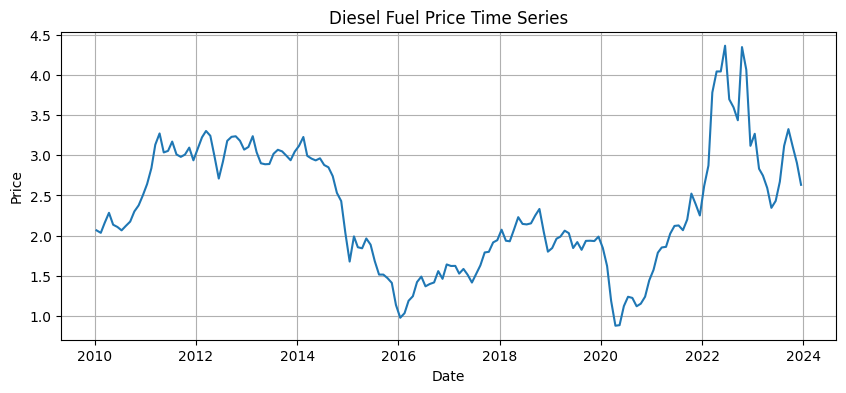

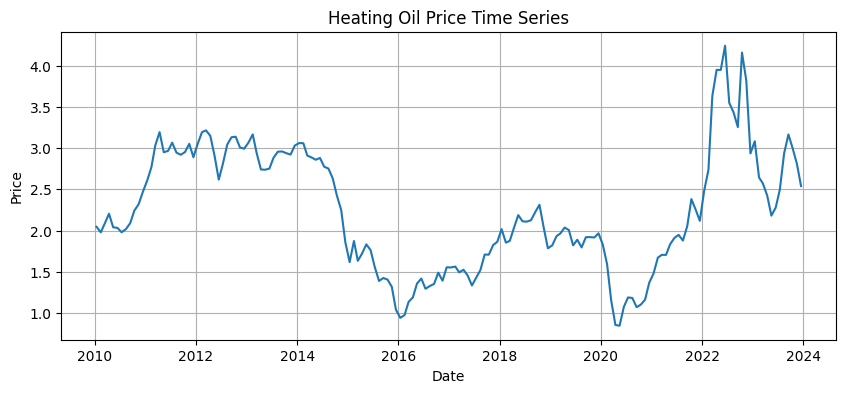

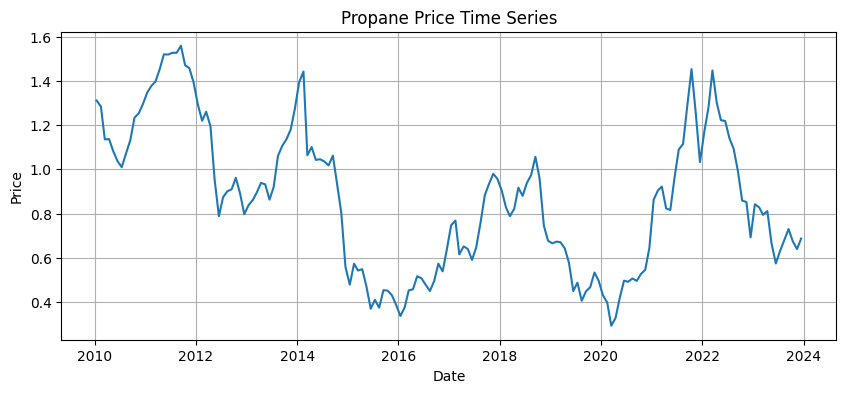

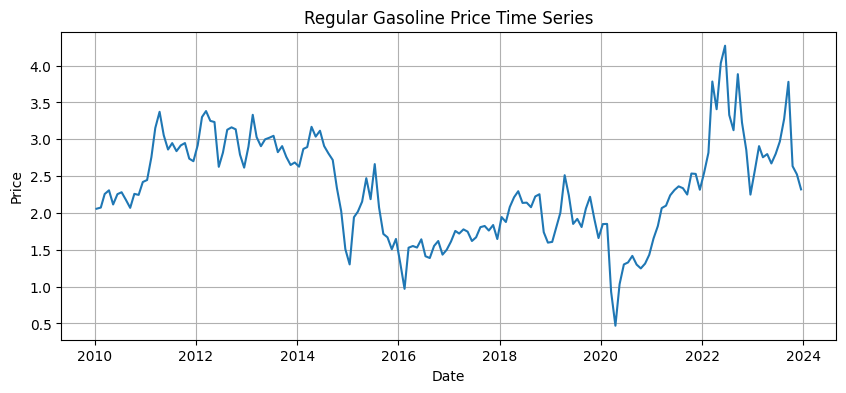

In [150]:
def time_series_analysis(df, title):
    plt.figure(figsize=(10, 4))
    plt.plot(df)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()

# Time series analysis
time_series_analysis(BFOE_df, 'BFOE Price Time Series')
time_series_analysis(Bonny_Light_df, 'Bonny Light Price Time Series')
time_series_analysis(Europe_Brent_df, 'Europe Brent Price Time Series')
time_series_analysis(WTI_df, 'WTI Price Time Series')
time_series_analysis(Conventional_Gasoline_df, 'Conventional Gasoline Price Time Series')
time_series_analysis(Diesel_Fuel_df, 'Diesel Fuel Price Time Series')
time_series_analysis(Heating_Oil_df, 'Heating Oil Price Time Series')
time_series_analysis(Propane_df, 'Propane Price Time Series')
time_series_analysis(Regular_Gasoline_df, 'Regular Gasoline Price Time Series')

#**STEP 4: Statistical Analysis**

In [151]:
def statistical_analysis(df):
    stats = df.describe()
    correlations = df.corr()
    return stats, correlations

# Perform statistical analysis
BFOE_stats, BFOE_correlations = statistical_analysis(BFOE_df)
Bonny_Light_stats, Bonny_Light_correlations = statistical_analysis(Bonny_Light_df)
Europe_Brent_stats, Europe_Brent_correlations = statistical_analysis(Europe_Brent_df)
WTI_stats, WTI_correlations = statistical_analysis(WTI_df)
Conventional_Gasoline_stats, Conventional_Gasoline_correlations = statistical_analysis(Conventional_Gasoline_df)
Diesel_Fuel_stats, Diesel_Fuel_correlations = statistical_analysis(Diesel_Fuel_df)
Heating_Oil_stats, Heating_Oil_correlations = statistical_analysis(Heating_Oil_df)
Propane_stats, Propane_correlations = statistical_analysis(Propane_df)
Regular_Gasoline_stats, Regular_Gasoline_correlations = statistical_analysis(Regular_Gasoline_df)

# Print statistics and correlations
print('BFOE Statistics:')
print(BFOE_stats)
print('BFOE Correlations:')
print(BFOE_correlations)
print('\nBonny Light Statistics:')
print(Bonny_Light_stats)
print('Bonny Light Correlations:')
print(Bonny_Light_correlations)
print('\nEurope Brent Statistics:')
print(Europe_Brent_stats)
print('Europe Brent Correlations:')
print(Europe_Brent_correlations)
print('\nWTI Statistics:')
print(WTI_stats)
print('WTI Correlations:')
print(WTI_correlations)
print('\nConventional Gasoline Statistics:')
print(Conventional_Gasoline_stats)
print('Conventional Gasoline Correlations:')
print(Conventional_Gasoline_correlations)
print('\nDiesel Fuel Statistics:')
print(Diesel_Fuel_stats)
print('Diesel Fuel Correlations:')
print(Diesel_Fuel_correlations)
print('\nHeating Oil Statistics:')
print(Heating_Oil_stats)
print('Heating Oil Correlations:')
print(Heating_Oil_correlations)
print('\nPropane Statistics:')
print(Propane_stats)
print('Propane Correlations:')
print(Propane_correlations)
print('\nRegular Gasoline Statistics:')
print(Regular_Gasoline_stats)
print('Regular Gasoline Correlations:')
print(Regular_Gasoline_correlations)

BFOE Statistics:
       Bloomberg European Dated Brent Forties Oseberg Ekofisk (BFOE) Crude Oil Spot Price
count                                         168.000000                                 
mean                                           64.535746                                 
std                                            18.631723                                 
min                                            21.462700                                 
25%                                            51.294475                                 
50%                                            62.984300                                 
75%                                            79.630675                                 
max                                           113.656300                                 
BFOE Correlations:
                                                    Bloomberg European Dated Brent Forties Oseberg Ekofisk (BFOE) Crude Oil Spot Price
Bloomberg European 

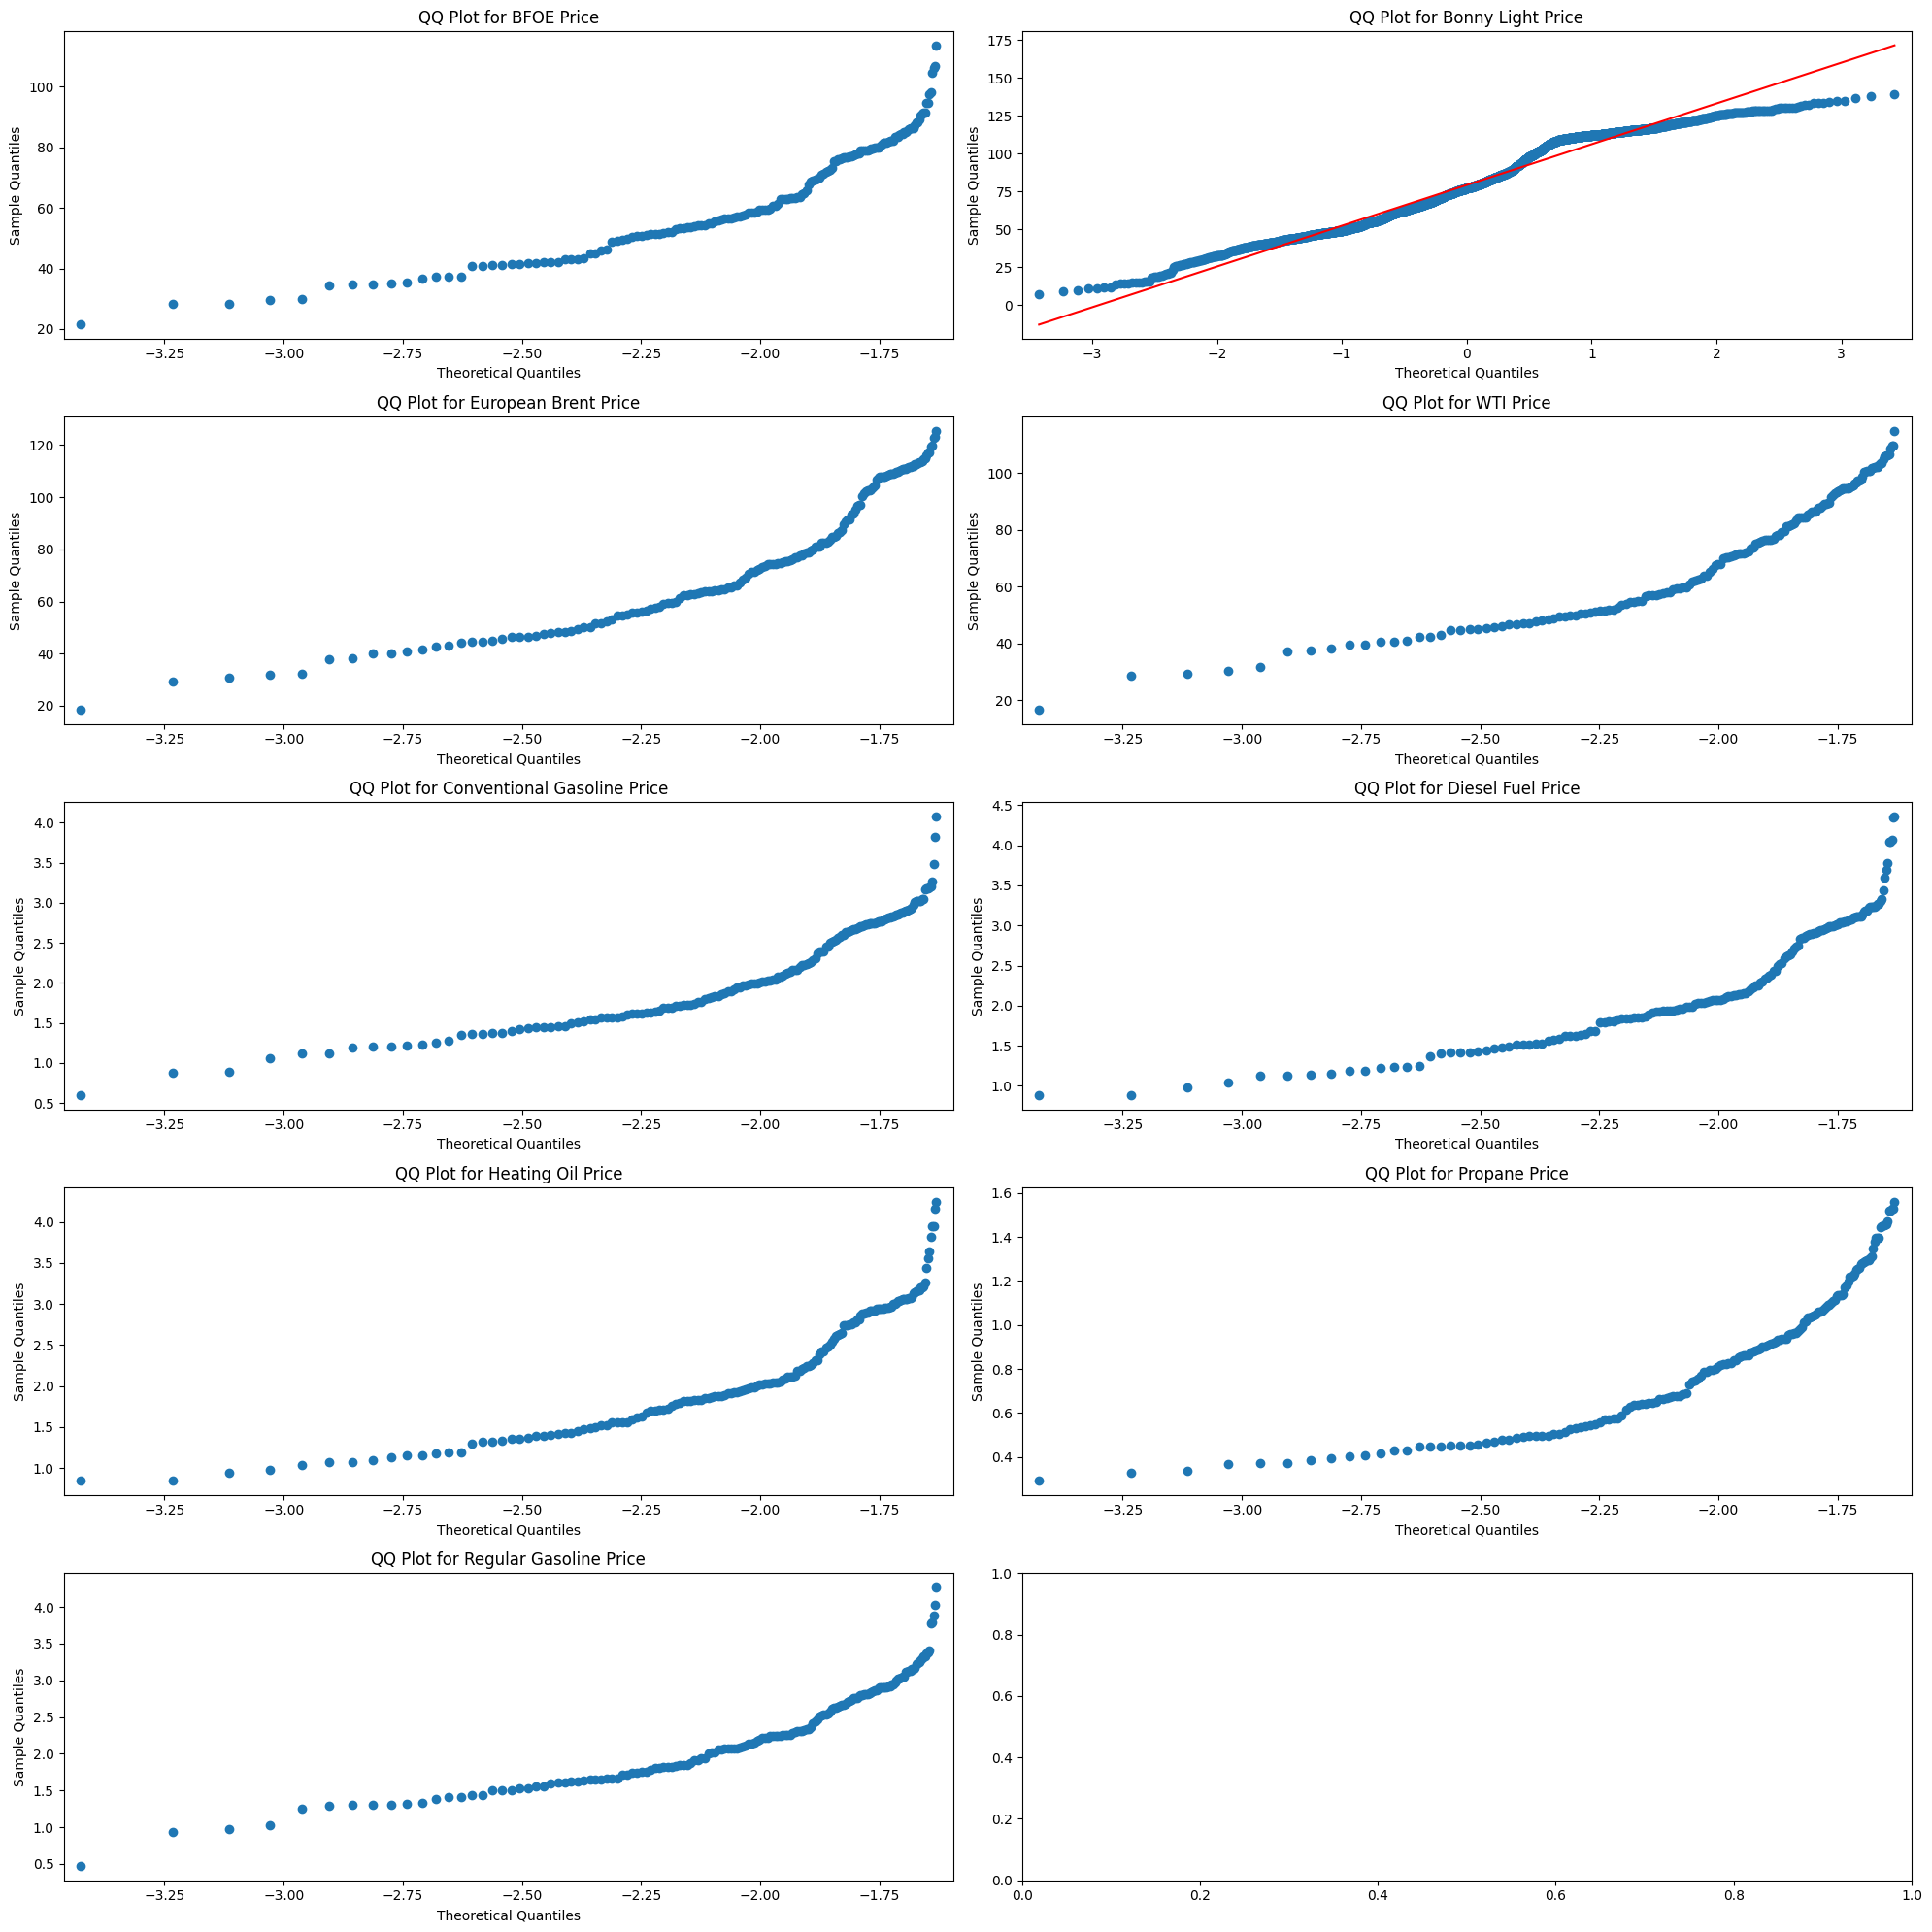

In [152]:
# Reset index
BFOE_df.reset_index(drop=True, inplace=True)
Bonny_Light_df.reset_index(drop=True, inplace=True)
Europe_Brent_df.reset_index(drop=True, inplace=True)
WTI_df.reset_index(drop=True, inplace=True)
Conventional_Gasoline_df.reset_index(drop=True, inplace=True)
Diesel_Fuel_df.reset_index(drop=True, inplace=True)
Heating_Oil_df.reset_index(drop=True, inplace=True)
Propane_df.reset_index(drop=True, inplace=True)
Regular_Gasoline_df.reset_index(drop=True, inplace=True)

# Concatenate the preprocessed DataFrames
all_processed_data = pd.concat([BFOE_df, Bonny_Light_df, Europe_Brent_df,
                                WTI_df, Conventional_Gasoline_df,
                                Diesel_Fuel_df, Heating_Oil_df, Propane_df,
                                Regular_Gasoline_df], axis=1)

# Q-Q Analysis
price_columns = ['Bloomberg European Dated Brent Forties Oseberg Ekofisk (BFOE) Crude Oil Spot Price',
                 'Crude Oil Price in USD',
                 'Europe Brent Spot Price FOB Dollars per Barrel',
                 'Cushing OK WTI Spot Price FOB Dollars per Barrel',
                 'New York Harbor Conventional Gasoline Regular Spot Price FOB (Dollars per Gallon)',
                 'New York Harbor Ultra-Low Sulfur No 2 Diesel Spot Price (Dollars per Gallon)',
                 'New York Harbor No. 2 Heating Oil Spot Price FOB (Dollars per Gallon)',
                 'Mont Belvieu, TX Propane Spot Price FOB (Dollars per Gallon)',
                 'Los Angeles Reformulated RBOB Regular Gasoline Spot Price (Dollars per Gallon)']

# Subplot Titles
subplot_titles = [
    'BFOE Price', 'Bonny Light Price', 'European Brent Price', 'WTI Price',
    'Conventional Gasoline Price', 'Diesel Fuel Price', 'Heating Oil Price',
    'Propane Price', 'Regular Gasoline Price'
]

# Create subplots
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
axs = axs.flatten()

# Plot Q-Q plots for each price column with custom titles
for i, col in enumerate(price_columns):
    sm.qqplot(all_processed_data[col], line='s', ax=axs[i])
    axs[i].set_title('QQ Plot for {}'.format(subplot_titles[i]))

plt.tight_layout()
plt.show()

In [153]:
# Concatenate the preprocessed DataFrames
all_processed_data = pd.concat([BFOE_df, Bonny_Light_df, Europe_Brent_df, WTI_df,
                                Conventional_Gasoline_df, Diesel_Fuel_df, Heating_Oil_df, Propane_df, Regular_Gasoline_df], axis=1)

# Extract the columns related to crude oil prices and refined products
price_columns = ['Bloomberg European Dated Brent Forties Oseberg Ekofisk (BFOE) Crude Oil Spot Price',
                 'Crude Oil Price in USD',
                 'Europe Brent Spot Price FOB Dollars per Barrel',
                 'Cushing OK WTI Spot Price FOB Dollars per Barrel']

product_columns = ['New York Harbor Conventional Gasoline Regular Spot Price FOB (Dollars per Gallon)',
                   'New York Harbor Ultra-Low Sulfur No 2 Diesel Spot Price (Dollars per Gallon)',
                   'New York Harbor No. 2 Heating Oil Spot Price FOB (Dollars per Gallon)',
                   'Mont Belvieu, TX Propane Spot Price FOB (Dollars per Gallon)',
                   'Los Angeles Reformulated RBOB Regular Gasoline Spot Price (Dollars per Gallon)']

# Rename columns in the correlation matrix
short_price_columns = ['BFOE', 'Crude Oil USD', 'Europe Brent', 'WTI']
short_product_columns = ['Conventional Gasoline', 'Diesel Fuel', 'Heating Oil', 'Propane', 'Regular Gasoline']

# Calculate the correlation matrix
correlation_matrix = all_processed_data[price_columns + product_columns].corr()

# Rename the columns in the correlation matrix
correlation_matrix.columns = short_price_columns + short_product_columns
correlation_matrix.index = short_price_columns + short_product_columns

# Display the correlation matrix
print("Correlation Matrix between Crude Oil Prices and Refined Products:")
print(correlation_matrix)

Correlation Matrix between Crude Oil Prices and Refined Products:
                           BFOE  Crude Oil USD  Europe Brent       WTI  \
BFOE                   1.000000       0.020791      0.115270  0.105614   
Crude Oil USD          0.020791       1.000000      0.045973 -0.000696   
Europe Brent           0.115270       0.045973      1.000000  0.980489   
WTI                    0.105614      -0.000696      0.980489  1.000000   
Conventional Gasoline  0.971880       0.005112      0.090285  0.077187   
Diesel Fuel            0.979285       0.041093      0.122942  0.110041   
Heating Oil            0.979667       0.016016      0.115833  0.105553   
Propane                0.680388      -0.164919      0.158616  0.133066   
Regular Gasoline       0.950042       0.068107      0.119540  0.110706   

                       Conventional Gasoline  Diesel Fuel  Heating Oil  \
BFOE                                0.971880     0.979285     0.979667   
Crude Oil USD                       0.005112 

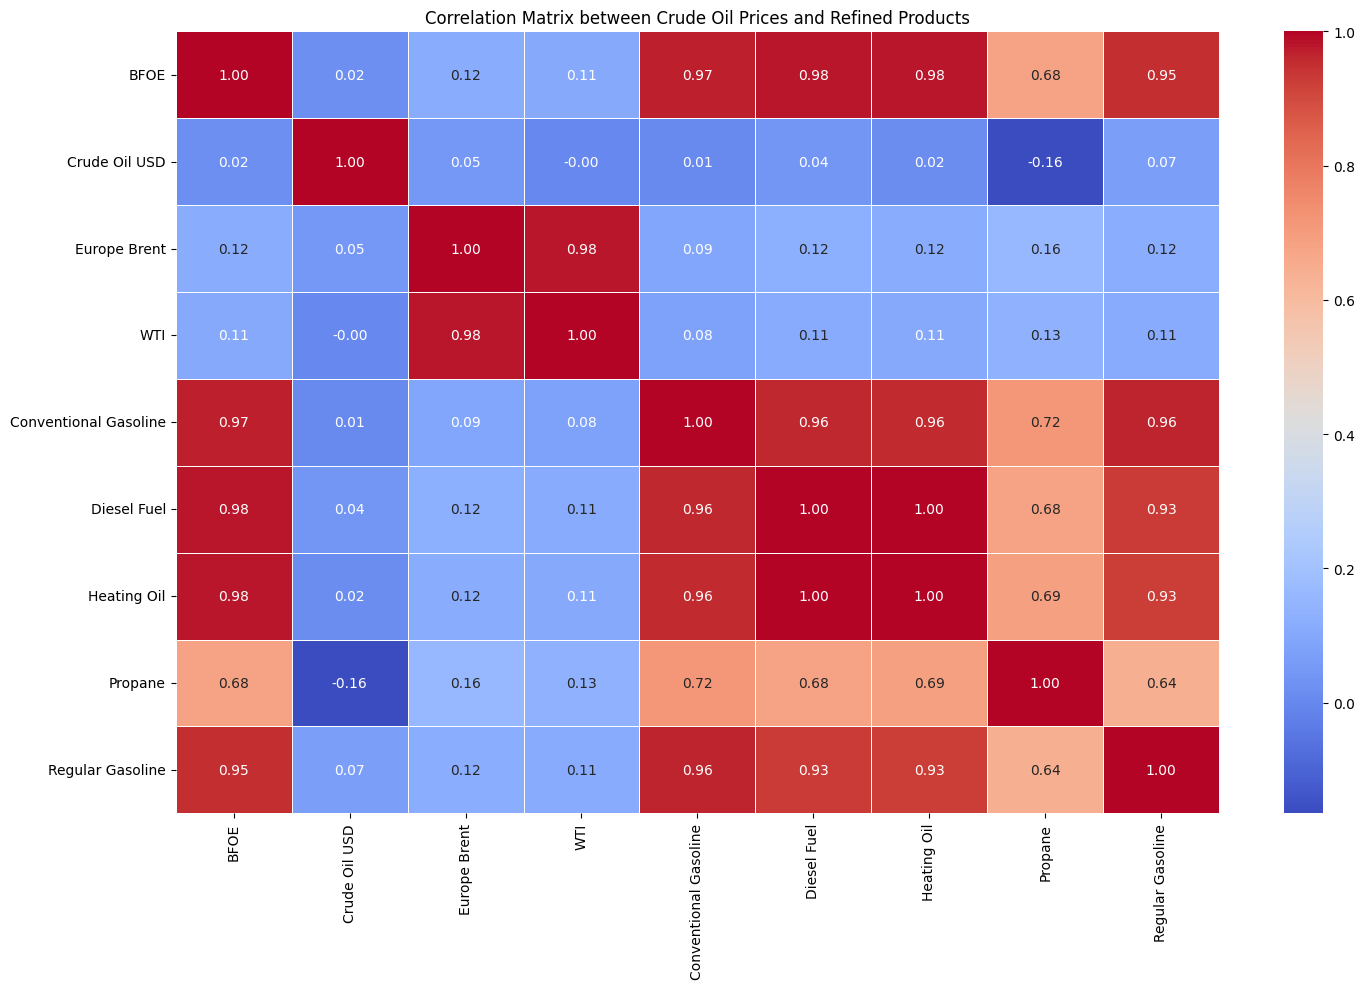

In [154]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Add title and adjust plot
plt.title('Correlation Matrix between Crude Oil Prices and Refined Products')
plt.tight_layout()

# Show plot
plt.show()

#**STEP 5: Model Development via Multivariate Techniques**

## **(a) PCA Technique**

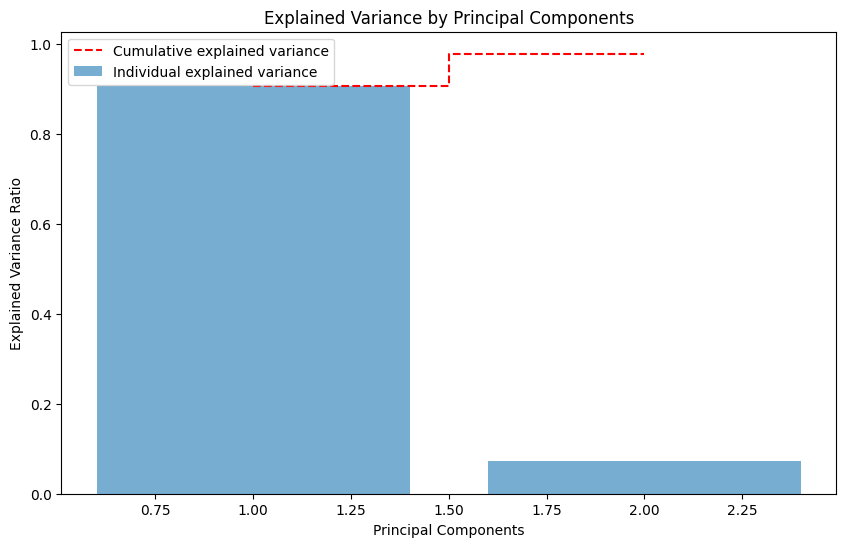

                                                         PC1       PC2
Bloomberg European Dated Brent Forties Oseberg ... -0.000119 -0.088778
Crude Oil Price in USD                             -1.000000  0.000293
Europe Brent Spot Price FOB Dollars per Barrel     -0.000365 -0.755871
Cushing OK WTI Spot Price FOB Dollars per Barrel   -0.000010 -0.648637
New York Harbor Conventional Gasoline Regular S... -0.000001 -0.002552
New York Harbor Ultra-Low Sulfur No 2 Diesel Sp... -0.000009 -0.003726
New York Harbor No. 2 Heating Oil Spot Price FO... -0.000004 -0.003517
Mont Belvieu, TX Propane Spot Price FOB (Dollar...  0.000016 -0.001754
Los Angeles Reformulated RBOB Regular Gasoline ... -0.000014 -0.003273
[[-8.54439378e-01  1.09694266e+00]
 [-1.75653351e+00 -6.74437476e+00]
 [-1.48990105e+00 -1.80550058e+01]
 ...
 [-3.70587917e+00  1.08587519e-03]
 [-1.72587932e+00  5.05707132e-04]
 [-1.85879434e-01  5.44653119e-05]]

Explained Variance Ratio:
[0.90493549 0.07243846]

Cumulative Variance Ra

In [155]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Data Preparation
# Extract the relevant columns for PCA
crude_and_refined_data = pd.concat([all_processed_data[price_columns], all_processed_data[product_columns]], axis=1)

# Check for infinity or very large values and replace them with NaN
crude_and_refined_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Initialize SimpleImputer to replace NaN values with the mean
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the data and transform it
X_imputed = imputer.fit_transform(crude_and_refined_data)

# PCA Initialization and Fitting
# Create a PCA object
pca = PCA(n_components=2)

# Fit the PCA object to the data
pca.fit(X_imputed)

# Transform the data using the PCA object
X_transformed = pca.transform(X_imputed)

# Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, 3), explained_variance_ratio, alpha=0.6, label='Individual explained variance')
plt.step(range(1, 3), cumulative_variance, where='mid', linestyle='--', color='red', label='Cumulative explained variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend(loc='best')
plt.show()

# Principal Component Loadings
loadings = pca.components_

# Create a DataFrame for better readability
loading_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(2)], index=crude_and_refined_data.columns)
print(loading_df)

# Analysis of Transformed Data
# Print the transformed data
print(X_transformed)

# Analysis
print("\nExplained Variance Ratio:")
print(explained_variance_ratio)
print("\nCumulative Variance Ratio:")
print(cumulative_variance)


 ## **(b) GARCH model**

Iteration:      1,   Func. Count:      5,   Neg. LLF: 4732.697554340444
Iteration:      2,   Func. Count:     11,   Neg. LLF: 932.202895247339
Iteration:      3,   Func. Count:     15,   Neg. LLF: 932.2027031874655
Iteration:      4,   Func. Count:     19,   Neg. LLF: 932.201944704129
Iteration:      5,   Func. Count:     23,   Neg. LLF: 932.2011298145198
Iteration:      6,   Func. Count:     26,   Neg. LLF: 932.2011298267994
Optimization terminated successfully    (Exit mode 0)
            Current function value: 932.2011298145198
            Iterations: 6
            Function evaluations: 26
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 973.9498112548687
Iteration:      2,   Func. Count:     10,   Neg. LLF: 973.8668320381921
Iteration:      3,   Func. Count:     14,   Neg. LLF: 973.8636590967183
Iteration:      4,   Func. Count:     18,   Neg. LLF: 973.8627224667084
Iteration:      5,   Func. Count:     22,   Neg. LLF: 973.8623350827045
Ite

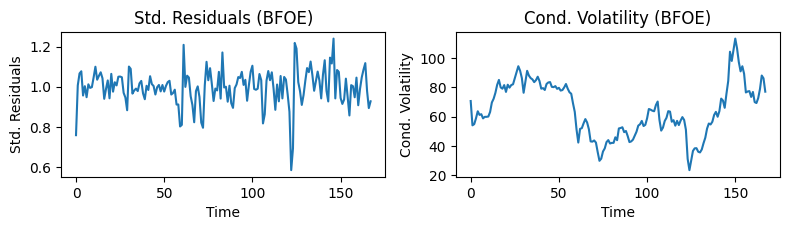

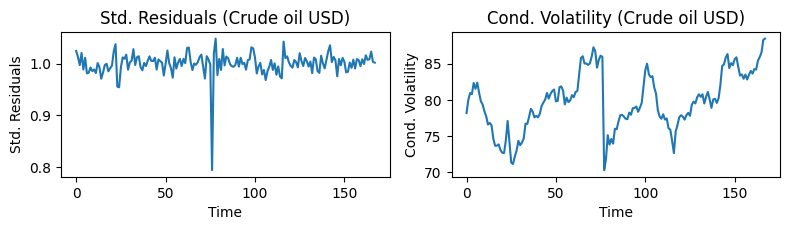

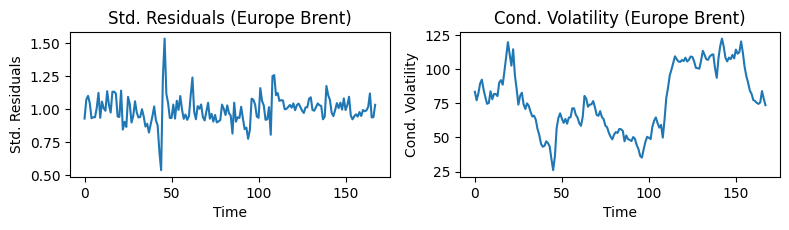

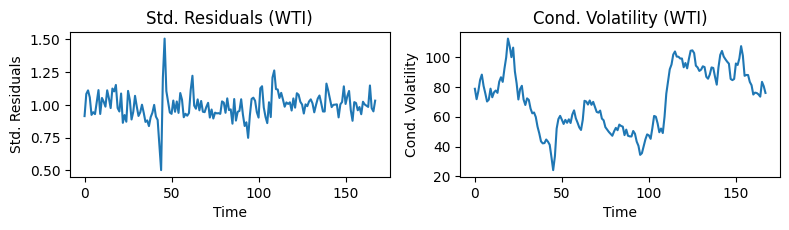

Summary for Bloomberg European Dated Brent Forties Oseberg Ekofisk (BFOE) Crude Oil Spot Price:
                                                       Zero Mean - GARCH Model Results                                                        
Dep. Variable:     Bloomberg European Dated Brent Forties Oseberg Ekofisk (BFOE) Crude Oil Spot Price   R-squared:                       0.000
Mean Model:                                                                                 Zero Mean   Adj. R-squared:                  0.006
Vol Model:                                                                                      GARCH   Log-Likelihood:               -932.201
Distribution:                                                                                  Normal   AIC:                           1870.40
Method:                                                                            Maximum Likelihood   BIC:                           1879.77
                                              

In [156]:
#GARCH model

# Define the oil prices for the columns
short_names = {
    'Bloomberg European Dated Brent Forties Oseberg Ekofisk (BFOE) Crude Oil Spot Price': 'BFOE',
    'Crude Oil Price in USD': 'Crude oil USD',
    'Europe Brent Spot Price FOB Dollars per Barrel': 'Europe Brent',
    'Cushing OK WTI Spot Price FOB Dollars per Barrel': 'WTI'
}

# Extract the relevant columns for GARCH modeling
oil_prices_data = all_processed_data[list(short_names.keys())]

# Drop rows with NaN values
oil_prices_data.dropna(inplace=True)

# Define a list to store the fitted models
fitted_models = []

# Fit separate GARCH models for each oil price series
for column in oil_prices_data.columns:
    oil_price_series = oil_prices_data[column]
    model = arch_model(oil_price_series, mean="Zero", vol="GARCH", p=1, q=1)
    model_fit = model.fit()
    fitted_models.append((column, model_fit))

# Plot the standardized residuals and conditional volatility with short names
for column, model_fit in fitted_models:
    # Plot the standardized residuals
    plt.figure(figsize=(8, 4))
    plt.subplot(2, 2, 1)
    plt.plot(model_fit.resid / model_fit.conditional_volatility)
    plt.title(f"Std. Residuals ({short_names[column]})")
    plt.xlabel("Time")
    plt.ylabel("Std. Residuals")

    # Plot the conditional volatility
    plt.subplot(2, 2, 2)
    plt.plot(model_fit.conditional_volatility)
    plt.title(f"Cond. Volatility ({short_names[column]})")
    plt.xlabel("Time")
    plt.ylabel("Cond. Volatility")

    plt.tight_layout()
    plt.show()

# Print summaries for each fitted model
for column, model_fit in fitted_models:
    print(f"Summary for {column}:")
    print(model_fit.summary())


Iteration:      1,   Func. Count:      5,   Neg. LLF: 85475148.59185788
Iteration:      2,   Func. Count:     11,   Neg. LLF: 362.8859395727391
Iteration:      3,   Func. Count:     15,   Neg. LLF: 362.98300337867875
Iteration:      4,   Func. Count:     20,   Neg. LLF: 362.8003020729355
Iteration:      5,   Func. Count:     24,   Neg. LLF: 362.7995512018915
Iteration:      6,   Func. Count:     28,   Neg. LLF: 362.7992516952197
Iteration:      7,   Func. Count:     32,   Neg. LLF: 362.7979146518469
Iteration:      8,   Func. Count:     36,   Neg. LLF: 362.7972578943058
Iteration:      9,   Func. Count:     40,   Neg. LLF: 362.79724776142433
Iteration:     10,   Func. Count:     44,   Neg. LLF: 362.7972471232913
Optimization terminated successfully    (Exit mode 0)
            Current function value: 362.7972471232913
            Iterations: 10
            Function evaluations: 44
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 86707926.889302

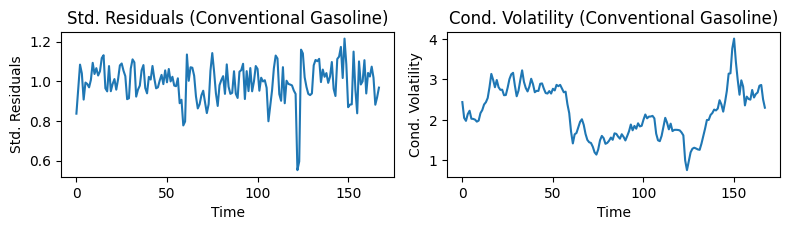

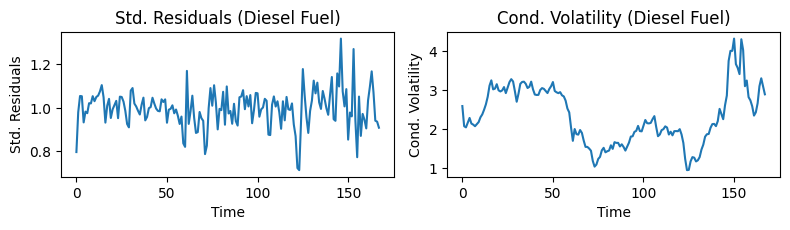

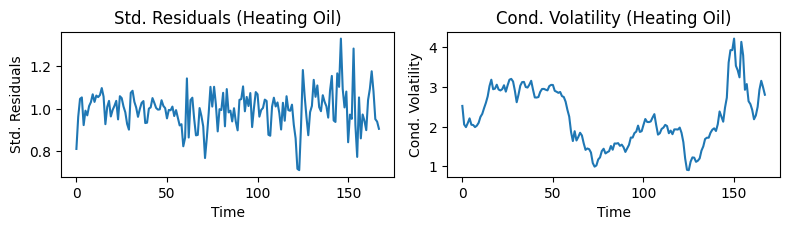

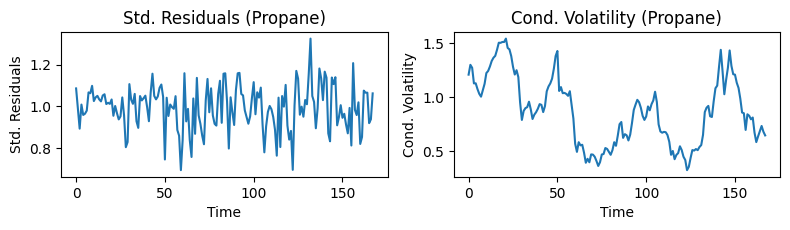

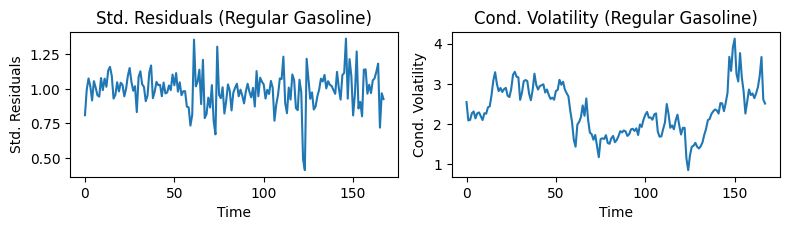

Summary for New York Harbor Conventional Gasoline Regular Spot Price FOB (Dollars per Gallon):
                                                       Zero Mean - GARCH Model Results                                                       
Dep. Variable:     New York Harbor Conventional Gasoline Regular Spot Price FOB (Dollars per Gallon)   R-squared:                       0.000
Mean Model:                                                                                Zero Mean   Adj. R-squared:                  0.006
Vol Model:                                                                                     GARCH   Log-Likelihood:               -362.797
Distribution:                                                                                 Normal   AIC:                           731.594
Method:                                                                           Maximum Likelihood   BIC:                           740.966
                                                     

In [157]:
# Define refined product price names for the columns
short_names = {
    'New York Harbor Conventional Gasoline Regular Spot Price FOB (Dollars per Gallon)': 'Conventional Gasoline',
    'New York Harbor Ultra-Low Sulfur No 2 Diesel Spot Price (Dollars per Gallon)': 'Diesel Fuel',
    'New York Harbor No. 2 Heating Oil Spot Price FOB (Dollars per Gallon)': 'Heating Oil',
    'Mont Belvieu, TX Propane Spot Price FOB (Dollars per Gallon)': 'Propane',
    'Los Angeles Reformulated RBOB Regular Gasoline Spot Price (Dollars per Gallon)': 'Regular Gasoline'
}

# Extract the relevant columns for GARCH modeling
refined_products_data = all_processed_data[list(short_names.keys())]

# Drop rows with NaN values
refined_products_data.dropna(inplace=True)

# Define a list to store the fitted models
fitted_models = []

# Fit separate GARCH models for each refined product price series
for column in refined_products_data.columns:
    refined_product_series = refined_products_data[column]
    model = arch_model(refined_product_series, mean="Zero", vol="GARCH", p=1, q=1)
    model_fit = model.fit()
    fitted_models.append((column, model_fit))

# Plot the standardized residuals and conditional volatility with short names
for column, model_fit in fitted_models:
    # Plot the standardized residuals
    plt.figure(figsize=(8, 4))
    plt.subplot(2, 2, 1)
    plt.plot(model_fit.resid / model_fit.conditional_volatility)
    plt.title(f"Std. Residuals ({short_names[column]})")
    plt.xlabel("Time")
    plt.ylabel("Std. Residuals")

    # Plot the conditional volatility
    plt.subplot(2, 2, 2)
    plt.plot(model_fit.conditional_volatility)
    plt.title(f"Cond. Volatility ({short_names[column]})")
    plt.xlabel("Time")
    plt.ylabel("Cond. Volatility")

    plt.tight_layout()
    plt.show()

# Print summaries for each fitted model
for column, model_fit in fitted_models:
    print(f"Summary for {column}:")
    print(model_fit.summary())

## **(c) LSTM**

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

In [159]:
# Define a function to prepare the data for LSTM
def prepare_lstm_data(df, look_back=1):
    """
    Prepare the data for LSTM model by converting it into a supervised learning problem.
    """
    data = df.values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    X, y = [], []
    for i in range(len(scaled_data) - look_back):
        X.append(scaled_data[i:(i + look_back), :])
        y.append(scaled_data[i + look_back, :])
    return np.array(X), np.array(y), scaler

# Define a function to create and train the LSTM model
def train_lstm_model(X_train, y_train, units=50, epochs=1000, batch_size=64):
    """
    Create and train an LSTM model.
    """
    model = Sequential()
    model.add(LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(y_train.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)
    return model, history

# Define a function to make predictions using the trained LSTM model
def make_lstm_forecast(model, X_test, scaler, test_size):
    """
    Make predictions using the trained LSTM model.
    """
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    # Trim predictions to match the test size
    predictions = predictions[-test_size:]
    return predictions

# Define a function to evaluate the LSTM model
def evaluate_lstm_model(y_true, y_pred):
    """
    Evaluate the LSTM model using Mean Squared Error (MSE).
    """
    mse = mean_squared_error(y_true, y_pred)
    return mse

def plot_forecast(actual, predicted, dataset_names, start_date='2010-01-01', end_date='2024-12-31', title='Forecast'):
    """
    Plot the actual vs. predicted values.
    """
    # Generate a time index from start_date to end_date
    time_index = pd.date_range(start=start_date, end=end_date, freq='D')

    plt.figure(figsize=(10, 20))

    # Iterate over each dataset
    for i, col in enumerate(dataset_names):
        plt.subplot(len(dataset_names), 1, i+1)
        plt.plot(time_index[-len(predicted):], actual[:, i], label='Actual', linestyle='-')
        plt.plot(time_index[-len(predicted):], predicted[:, i], label='Predicted', linestyle='--')
        plt.title(f'{title} - {col}')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()

    plt.tight_layout()
    plt.show()



Epoch 1/1000
2/2 - 3s - loss: 0.1827 - 3s/epoch - 2s/step
Epoch 2/1000
2/2 - 0s - loss: 0.1336 - 97ms/epoch - 48ms/step
Epoch 3/1000
2/2 - 0s - loss: 0.0967 - 77ms/epoch - 39ms/step
Epoch 4/1000
2/2 - 0s - loss: 0.0689 - 81ms/epoch - 41ms/step
Epoch 5/1000
2/2 - 0s - loss: 0.0493 - 77ms/epoch - 38ms/step
Epoch 6/1000
2/2 - 0s - loss: 0.0375 - 83ms/epoch - 42ms/step
Epoch 7/1000
2/2 - 0s - loss: 0.0321 - 118ms/epoch - 59ms/step
Epoch 8/1000
2/2 - 0s - loss: 0.0310 - 79ms/epoch - 40ms/step
Epoch 9/1000
2/2 - 0s - loss: 0.0313 - 89ms/epoch - 45ms/step
Epoch 10/1000
2/2 - 0s - loss: 0.0313 - 114ms/epoch - 57ms/step
Epoch 11/1000
2/2 - 0s - loss: 0.0307 - 90ms/epoch - 45ms/step
Epoch 12/1000
2/2 - 0s - loss: 0.0296 - 73ms/epoch - 36ms/step
Epoch 13/1000
2/2 - 0s - loss: 0.0281 - 84ms/epoch - 42ms/step
Epoch 14/1000
2/2 - 0s - loss: 0.0265 - 83ms/epoch - 41ms/step
Epoch 15/1000
2/2 - 0s - loss: 0.0248 - 75ms/epoch - 38ms/step
Epoch 16/1000
2/2 - 0s - loss: 0.0231 - 74ms/epoch - 37ms/step
Epo

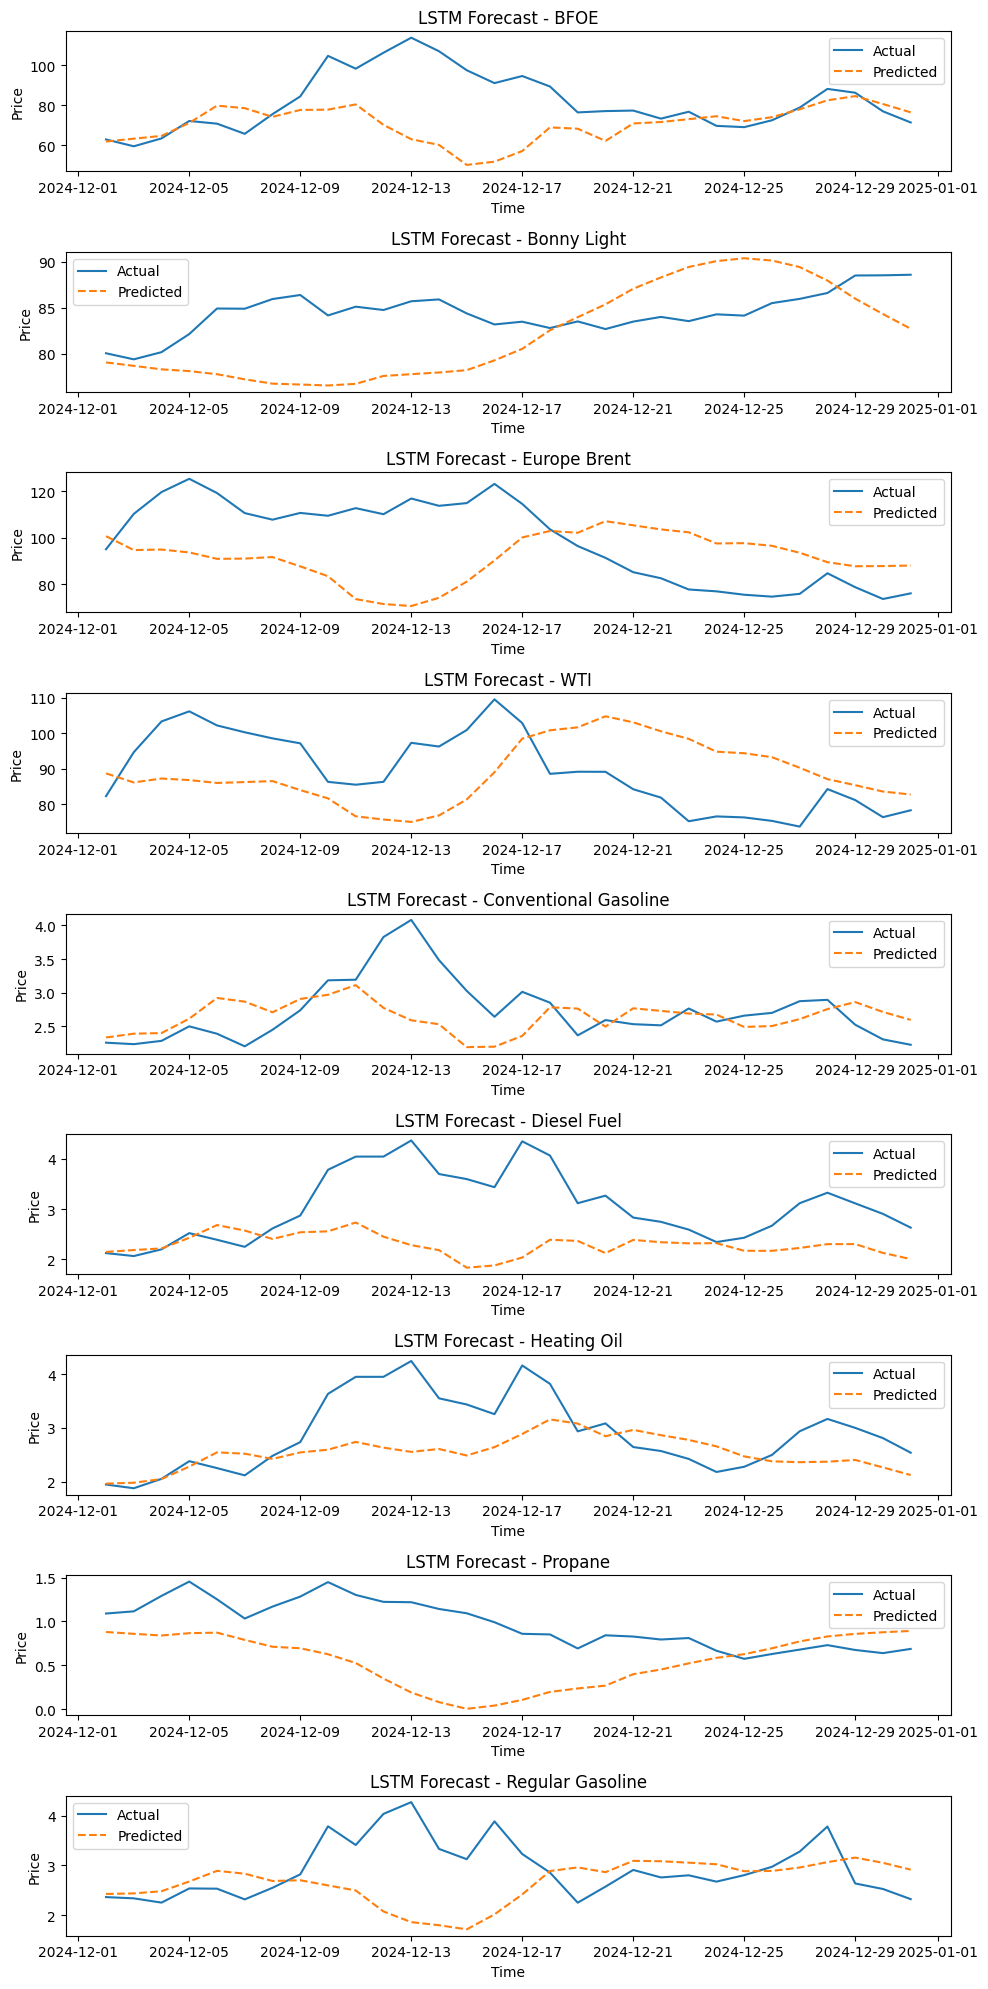

In [160]:
# Drop rows with NaN values from crude_and_refined_data
all_processed_data.dropna(inplace=True)

# Prepare data for LSTM
look_back = 50  # Adjust as needed
X_lstm, y_lstm, scaler_lstm = prepare_lstm_data(all_processed_data, look_back)

# Split data into training and testing sets
train_size = int(len(X_lstm) * 0.75)
test_size = len(X_lstm) - train_size
X_train_lstm, X_test_lstm = X_lstm[0:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[0:train_size], y_lstm[train_size:]

# Reshape input to be [samples, time steps, features]
X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], X_train_lstm.shape[2]))
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], X_test_lstm.shape[2]))

# Train LSTM model
lstm_model, lstm_history = train_lstm_model(X_train_lstm, y_train_lstm)

# Make predictions using LSTM model
lstm_predictions = make_lstm_forecast(lstm_model, X_test_lstm, scaler_lstm, test_size)

# Inverse transform actual values for plotting
actual_values = scaler_lstm.inverse_transform(y_test_lstm)

# Evaluate LSTM model
mse_lstm = evaluate_lstm_model(y_test_lstm, lstm_predictions)
print("Mean Squared Error (LSTM):", mse_lstm)

dataset_names = ['BFOE', 'Bonny Light', 'Europe Brent', 'WTI', 'Conventional Gasoline',
                 'Diesel Fuel', 'Heating Oil', 'Propane', 'Regular Gasoline']

#plot_forecast(actual_values, lstm_predictions, dataset_names, title='LSTM Forecast')
plot_forecast(actual_values, lstm_predictions, dataset_names, start_date='2010-01-01', end_date='2024-12-31', title='LSTM Forecast')

